![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 5 - PyTorch</center>
### <center> Cifar-10 Example - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/05_PyTorch/MainPyTorchCifar_Solution.ipynb)

In [2]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

#-- torch:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchinfo

# #-- Fix seed (for presentation sake)
# torch.manual_seed(0)
# np.random.seed   (0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False

In [4]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
        
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)
            loss = Loss(mZ, vY)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric

### Exercise:
* Use the California housing dataset `fetch_california_housing`.
* Use MSE loss (instead of the cross-entropy)
* Replace the classification accuracy with $R^2$ score.
* Try to get the best MSE\R2 score you can.

**Tips**:
* You should test different models (layers\activations) and hyper-parameters.
* Try different optimizers and regularizations.
* $R_2 > 0.8$ (on the validation set) is quite good.

In [5]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= mX.mean(0)
mX     /= mX.std (0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [6]:
from torch.utils.data import TensorDataset

nTrain              = 15000
nTest               = 5640
oDataset            = TensorDataset(torch.tensor(mX, dtype=torch.float32), torch.tensor(vY, dtype=torch.float32))
oTrainSet, oValSet  = torch.utils.data.random_split(oDataset, [nTrain, nTest])
len(oTrainSet), len(oValSet)

(15000, 5640)

#### $R^2$ function
`tensor.detach()` creates a tensor that shares storage with `tensor` that does not require grad.

In [7]:
from sklearn.metrics import r2_score

def R2Score(vHatY, vY):
    vY    = vY   .detach().cpu().view(-1)
    vHatY = vHatY.detach().cpu().view(-1)
    return r2_score(vY, vHatY)

In [8]:
import time

def TrainRegressionModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainR2   = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValR2     = np.full(nEpochs, np.nan)
    bestR2     = 0

    for epoch in range(nEpochs):
        startTime = time.time()
        trainLoss, trainR2 = Epoch(oModel, oTrainData, Loss, R2Score, oOptim, bTrain=True ) #-- train
        valLoss,   valR2   = Epoch(oModel, oValData,   Loss, R2Score,         bTrain=False) #-- validate
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '          f'{epoch    :03d}:',   end='')
        print(' | Train loss: ' f'{trainLoss:6.3f}' ,  end='')
        print(' | Val loss: '   f'{valLoss  :6.3f}' ,  end='')
        print(' | Train R²: '   f'{trainR2 :+6.3f}',   end='')
        print(' | Val R²: '     f'{valR2   :+6.3f}',   end='')
        print(' | epoch time: ' f'{epochTime:3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainR2  [epoch] = trainR2
        vValLoss  [epoch] = valLoss
        vValR2    [epoch] = valR2

        #-- Save best model (early stopping):
        if bestR2 < valR2:
            bestR2 = valR2
            try:
                dCheckpoint = {'Model'     : oModel.state_dict(),
                               'Optimizer' : oOptim.state_dict()}
                torch.save(dCheckpoint, 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    dCheckpoint = torch.load('BestModel.pt')
    oModel.load_state_dict(dCheckpoint['Model'])

    return vTrainLoss, vTrainR2, vValLoss, vValR2

In [9]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY       = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([128, 8]), torch.Size([128]))

In [10]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchinfo

#-- Model:
def GetModel():
    p      = 0.1
    oModel = nn.Sequential(
        nn.Identity(),  #-- does nothing
        nn.Linear (8,   900), nn.LeakyReLU(), nn.Dropout(p),
        nn.Linear (900, 700), nn.LeakyReLU(), nn.Dropout(p),
        nn.Linear (700, 500), nn.LeakyReLU(), nn.Dropout(p),
        nn.Linear (500, 300), nn.LeakyReLU(), nn.Dropout(p),
        nn.Linear (300, 100), nn.LeakyReLU(), nn.Dropout(p),
        nn.Linear (100, 1),
        nn.Flatten(start_dim=0)
    )
    
    def InitWeights(oLayer):
        if isinstance(oLayer, nn.Linear):
            nn.init.kaiming_normal_(oLayer.weight.data)

    oModel.apply(InitWeights)
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 8]                  --
├─Linear: 1-2                            [128, 900]                8,100
├─LeakyReLU: 1-3                         [128, 900]                --
├─Dropout: 1-4                           [128, 900]                --
├─Linear: 1-5                            [128, 700]                630,700
├─LeakyReLU: 1-6                         [128, 700]                --
├─Dropout: 1-7                           [128, 700]                --
├─Linear: 1-8                            [128, 500]                350,500
├─LeakyReLU: 1-9                         [128, 500]                --
├─Dropout: 1-10                          [128, 500]                --
├─Linear: 1-11                           [128, 300]                150,300
├─LeakyReLU: 1-12                        [128, 300]                

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [12]:
nEpochs  = 100
Loss     = nn.MSELoss()

oModel   = GetModel            ().to(DEVICE)
oOptim   = optim.AdamW         (oModel.parameters(), lr=1e-3, betas=(0.9, 0.99), weight_decay=3e-5)
lHistory = TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim);

Epoch 000: | Train loss:  1.685 | Val loss:  0.686 | Train R²: -0.287 | Val R²: +0.489 | epoch time: 1.457 | <-- Checkpoint!
Epoch 001: | Train loss:  2.760 | Val loss:  0.523 | Train R²: -0.953 | Val R²: +0.610 | epoch time: 0.360 | <-- Checkpoint!
Epoch 002: | Train loss:  3.510 | Val loss:  2.344 | Train R²: -2.907 | Val R²: -0.747 | epoch time: 0.341 |
Epoch 003: | Train loss: 13.824 | Val loss:  0.458 | Train R²: -10.759 | Val R²: +0.660 | epoch time: 0.337 | <-- Checkpoint!
Epoch 004: | Train loss:  1.091 | Val loss:  5.326 | Train R²: +0.226 | Val R²: -2.973 | epoch time: 0.336 |
Epoch 005: | Train loss:  4.677 | Val loss:  0.715 | Train R²: -2.432 | Val R²: +0.455 | epoch time: 0.351 |
Epoch 006: | Train loss: 10.189 | Val loss:  0.443 | Train R²: -7.420 | Val R²: +0.672 | epoch time: 0.337 | <-- Checkpoint!
Epoch 007: | Train loss:  1.468 | Val loss:  0.373 | Train R²: -0.250 | Val R²: +0.724 | epoch time: 0.351 | <-- Checkpoint!
Epoch 008: | Train loss:  0.476 | Val loss:  0.

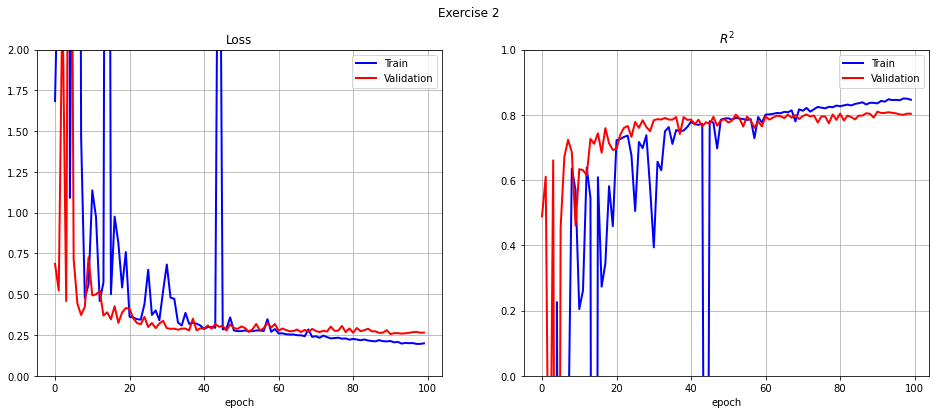

In [13]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainR2, vValLoss, vValR2 = lHistory
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('epoch')
    plt.ylim   ([0, 2])
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainR2, 'b', lw=2, label='Train'     )
    plt.plot   (vValR2,   'r', lw=2, label='Validation')
    plt.title  ('$R^2$')
    plt.xlabel ('epoch')
    plt.ylim   ([0, 1])
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('Exercise 2')
plt.show    ()

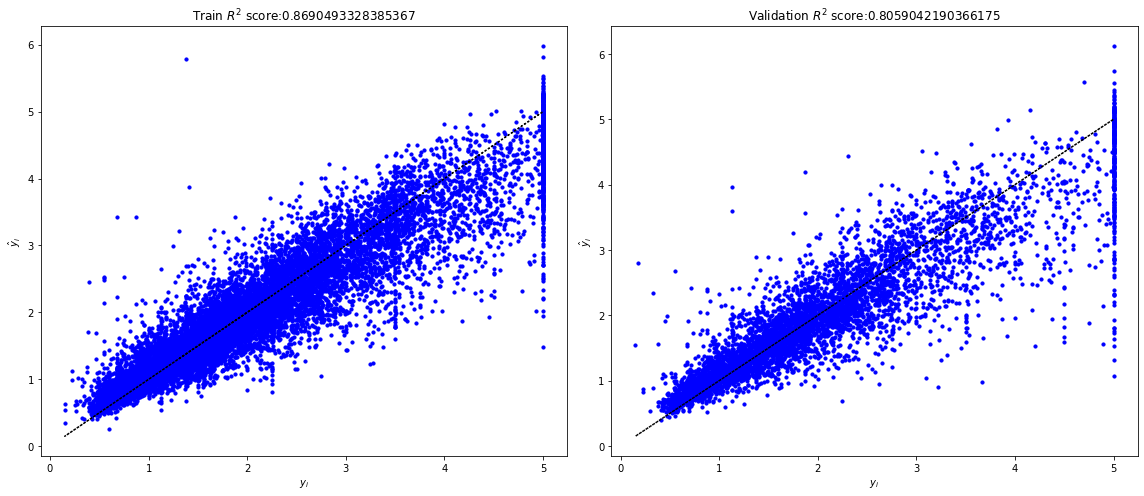

In [14]:
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score

#-- Entire dataset in one batch:
mTrainX, vTrainY = next(iter(DataLoader(oTrainSet, shuffle=False, batch_size=nTrain)))
mValX,   vValY   = next(iter(DataLoader(oValSet,   shuffle=False, batch_size=nTest )))

#-- Apply model to data:
with torch.no_grad():
    vHatTrainY = oModel(mTrainX.to(DEVICE)).detach().cpu()
    vHatValY   = oModel(mValX  .to(DEVICE)).detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vValY,   vHatValY,   s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vValY,   vValY,   ':k')
ax[0].set_title ('Train $R^2$ score:'      f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Validation $R^2$ score:' f'{r2_score(vValY,   vHatValY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')

plt.tight_layout()
plt.show        ()